<a href="https://colab.research.google.com/github/mhisle22/Data-Science-Projects/blob/master/dsc305_lab04_hisle_mark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mark Hisle  
Matthew Ko  
DSC 305A S20  
Lab 4: Heart Stoppers & Shrooms

**As a preliminary step, work through the following tutorial:**

[Understanding Logistic Regression in Python](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python) (DataCamp)

*You will **not** submit your work with the tutorial.  However, completing the tutorial will be of great help to you as you work through this and future labs.* *Note that in the interest of keeping things simple, tutorials often omit steps that you should not, such as scaling the data.*

*I also strongly suggest reading: [6 amateur mistakes I’ve made working with train-test splits](https://towardsdatascience.com/6-amateur-mistakes-ive-made-working-with-train-test-splits-916fabb421bb) (Toward Data Science)*

In [0]:
import numpy as np
import pandas as pd
from sklearn import metrics #for visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import itertools

%matplotlib inline

## Part A: Predicting heart disease

**1. Import the [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci/) dataset from Kaggle.**

*The data set was [originally hosted on the UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).  Study that site carefully, [as well as the the Kaggle site](https://www.kaggle.com/ronitf/heart-disease-uci/) to learn more about the data set. (You cannot work effectively with data without knowing at least a little about its context!)*

_As in your other labs, your answers to the questions will consist of the following:_ 
* _Markdown cell with a statement of the problem, question, or task._ 
* _One or more Code cells (with output) that performs the necessary analytic work._
* _Markdown cell with one or more sentences in English that summarize your answer._ 

In [0]:
heart = pd.read_csv('heart.csv')
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


**2. Explore the data set.**

*Look closely at the various fields and the data they contain. Pay attention to missing data, duplicate data, or potential problems that you may encounter in working with this data set. Note that in this step, you are just exploring the data and making observations. You will address any problems that you discover in the next step.* 

In [0]:
heart.isna().any()
heartCount = heart.count()
heartCount

age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          303
thal        303
target      303
dtype: int64

Lucky for us there does not appear to be any missing data.

In [0]:
duplicates = heart[heart.duplicated(keep='last')]
duplicates

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


We have exactly one duplicate, so drop that. Even though one is not usually significant, it is important for this specific set as there are few data entries.

In [0]:
heart = heart.drop(duplicates.index)
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


After taking a closer look at the data, we notice a few issues that need to be addressed. Consulting the kaggle article associated with this dataset, we have come to realize that this data set contains both numerical and categorical data that is displayed in a variety of forms. Below is a recording of these categorical variables.    
   
Categorical variables being changed to one-hot encode:
* cp (-- Value 0: asymptomatic, -- Value 1: atypical angina, -- Value 2: non-anginal pain, -- Value 3: typical angina)
* restecg (-- Value 0: showing probable or definite left ventricular hypertrophy by Estes criteria, -- Value 1: normal, Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))
* slope (0: downsloping; 1: flat; 2: upsloping)
* thal (thal: 1 = fixed defect; 2 = normal; 7 = reversable defect)

Naturally, we will want to convert these to usable data for our model. Therefore, in the next step we will one-hot encode these columns, making them uniform and compatible with the rest of the data.

**3. Prepare the data for modeling.**

*Address any issues that you discovered in the previous step.  You may need to transform your data in various ways.*

**Note: Remember that while logistic regression has categorical output, the inputs are expected to be numeric.  So be careful to model those categorical inputs correctly!**  *(Hint: Use the method of [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)!)*

*In this step you will also partition your data into training and test sets.* 

In [0]:
#pandas function allowing categorical variables to be turned into one-hot encode columns
heart = pd.get_dummies(heart, columns=['cp', 'restecg', 'slope', 'thal'])
heart

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,...,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,1,0,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,0,...,0,1,0,0,1,0,0,0,0,1
299,45,1,110,264,0,132,0,1.2,0,0,...,0,1,0,0,1,0,0,0,0,1
300,68,1,144,193,1,141,0,3.4,2,0,...,0,1,0,0,1,0,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,0,...,0,1,0,0,1,0,0,0,0,1


New columns above (restecg_1, slope_0, etc.) are the encoded categorical fields.

In [0]:
X = heart.loc[:, heart.columns != 'target']
y = heart['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
distribution = [np.sum([y_test == y]) for y in [0,1]]
distribution

[27, 34]

It appears that our data in our test set contains a sufficient number of both positive and negative classes, so we will not attempt another data splitting method.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Data is scaled and transformed above using standard MinMaxScaler.

**4. Fit logistic regression model to the data.**

*Apply logistic regression to your transformed data using the sklearn toolkit and other tools introduced in this course.  Experiment with hyperparameters to get the best fit you can.* 

In [0]:
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           C=1.0,
                           random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Naturally this is a logistic regression problem, as we are categorizing patients into 2 separate classes, making it fit perfectly for this type of model.  
Here we used random state 0- the next data set uses 42 just for the record.

In [0]:
w = model.coef_
w0 = model.intercept_
print('w =', w)
print('w0 =', w0)

w = [[-0.06012874 -0.67157464 -0.48684506 -0.28356149 -0.05719554  0.64247
  -0.26322092 -0.80505304 -1.44028919 -0.52762227  0.00583993  0.20095327
   0.32072634  0.02808884  0.13801824 -0.16620981  0.01885593 -0.23359905
   0.21464039 -0.11714597  0.13720324  0.32106848 -0.34122848]]
w0 = [0.95853484]


In [0]:
model.score(X_train, y_train)

0.8589211618257261

There does not appear to be any sign of overfitting here, as this value is sufficiently low.

**5. Evaluate your models.**

*Evaluate your models using appropriate methods, including accuracy, AUC, and confusion matrix* 

In [0]:
y_predict = model.predict(X_test)
model.score(X_test, y_test)

0.8852459016393442

Performance on the test data seems to come in around 88%- not bad.

In [0]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        27
           1       0.94      0.85      0.89        34

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



Evaluation metrics seem to be consistently around 88%, leading us to believe that there is no hidden issue with our model here.

In [0]:
cnf_matrix = confusion_matrix(y_test, y_predict)
print(cnf_matrix)

[[25  2]
 [ 5 29]]


**6. Analysis.**

*Summarize your findings in English, with the help of appropriate data visulization tools.* 

#Summary
The evaluuation statistics above, as well as the overall performance score of the model, show that we have a fairly effective model when predicting the presence of a heart disease in the patients of this data set. Coming in at around 88%, this model can accurately classify patients as healthy or not healthy given the above health data collected on them. However, it is important to note that this this metric can be considered quite low for the problem involved- when seeking to measure the presence of a heart disease, a false negative can be quite problematic. Therefore, we shall look closer into the model's performance on this below. 

Text(0.5, 257.44, 'Predicted label')

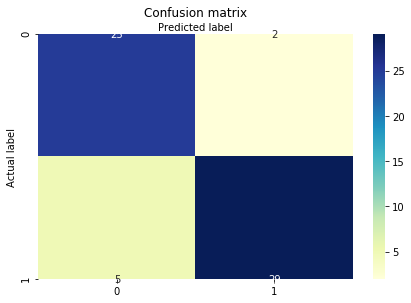

In [0]:
#visualization of confusion matrix
#credit goes to tutorial listed above
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap, confusion matrix calculated above
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The confusion matrix of this model shows that the model incorrectly labeled patients with the heart disease as healthy on 5 instances. While this is clearly quite low compared to correct estimations, this could be quite serious depending upon the severity of the disease. In comparison, the model only had 2 false positives out of the test set. However, errors happened less frequently than correct estimations, so this model is not entirely useless.

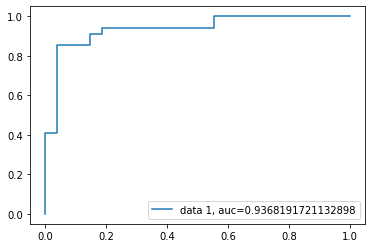

In [0]:
#AUC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The AUC curve above shows that our model can correctly distinguish between positive and negative classes around 94% of the time, thus making it highly effective at differentiating patients. This supports the claim above that the model does have a high degree of usability. In addition to this, this shows that this model did not run into an issue of exclusively estimating one class or the other, thus supporting the claim that it can indeed differentiate between the two.

In conclusion, our model is effective at categorizing heart disease patients but could benefit from extra work in order to increase its accuracy. This could involve collecting more data entries, as there were only a few hundred patients in the data set, tweaking hyperparamters, and searching for data with additional fields for more characteristics on the patients.

## Part B: Classifying mushrooms

**Import the [Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification) (UCI) dataset from Kaggle.**

**Follow the same steps as for Part A&mdash;explore the data, prepare the data for modeling, fit logistic regression models, and evaluate your results.  Conclude by summarizing your experiment and major findings.**

*Hint: Usually you should be very, very suspicious of 100% accuracy.  However, when data are linearly separable, it is possible to obtain a perfect classifier using logistic regression and other linear classification models.*

**Also remember to include a brief description of what you learned in this assignment.** 

*Check that you have followed all of the steps described in the General Instructions for Lab Reports and the Lab Scoring Rubric.  Proofread your report carefully.  Then upload it to Moodle along with all data and any other files needed to compile your notebook.*

*As always, please see me ASAP if you have questions or run into any problems. Good luck!*

#Data Exploration & Cleaning

In [0]:
shroom = pd.read_csv('mushrooms.csv')
shroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


Lioke the previous data set, it appears that most if not all fields here are categorical, non-numerical data that cannot be used by sklearn in its current form. 

In [0]:
shroom.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


The description of the data shows that the above assumption is true- all of the above fields are categorical data. Because of this, we will need to transform these fields into one-hot encoded columns like before in order to use the data.

In [0]:
shroom.isna().any()
shroomCount = shroom.count()
shroomCount

class                       8124
cap-shape                   8124
cap-surface                 8124
cap-color                   8124
bruises                     8124
odor                        8124
gill-attachment             8124
gill-spacing                8124
gill-size                   8124
gill-color                  8124
stalk-shape                 8124
stalk-root                  8124
stalk-surface-above-ring    8124
stalk-surface-below-ring    8124
stalk-color-above-ring      8124
stalk-color-below-ring      8124
veil-type                   8124
veil-color                  8124
ring-number                 8124
ring-type                   8124
spore-print-color           8124
population                  8124
habitat                     8124
dtype: int64

There does not appear to be any missing data in this set.

In [0]:
duplicates = shroom[shroom.duplicated(keep='last')]
duplicates

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


We are lucky this time- there are also no duplicate points.

In [0]:
shroom = shroom.drop(duplicates.index)
shroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


All columns save the dependent variable (class) will need to be one-hot encoded like before. In addition to this, we decided to reinterpret the class field as 0 and 1 instead of p (poisonous) and e (edible) for ease of use.

In [0]:
X = shroom.loc[:, shroom.columns != 'class']
shroom2 = shroom.replace(['p', 'e'], [0, 1])
shroom2 = pd.get_dummies(shroom2, columns=X.columns)
shroom2

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_0,habitat_d,habitat_g,habitat_l,habitat_m,habitat_u,habitat_w
0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8120,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0
8121,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8122,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [0]:
shroom = shroom2

Now that we have changed our data into something useful, we can begin to work on modeling it.
#Data Preperation

In [0]:
X = shroom.loc[:, shroom.columns != 'class']
y = shroom['class']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=42)

In [0]:
distribution = [np.sum([y_test == y]) for y in [0,1]]
distribution

[782, 843]

The train-test split appears to have provided the test set with an acceptable distribution of both classes.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Scale the data before training for ease of use by the machine learning algorithms.

#Training

In [0]:
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           C=1.0,
                           random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Once again like before, we will use logistic regression here as there are only two classes for the dependent variable.

In [0]:
model.score(X_train, y_train)

1.0

It appears that we may have overfitted our model to the data or the two classes are linearly separable. Further evaluation may help with this.
#Evaluation

In [0]:
y_predict = model.predict(X_test)
model.score(X_test, y_test)

1.0

Our model may have perfectly linearly separated this data. This either indicates that the variables provided allowed for perfect classification of mushrooms, or our model has overfitted to the data.

In [0]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       782
           1       1.00      1.00      1.00       843

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



Naturally all evaluation metrics also are at 100%

In [0]:
cnf_matrix = confusion_matrix(y_test, y_predict)
print(cnf_matrix)

[[782   0]
 [  0 843]]


Text(0.5, 257.44, 'Predicted label')

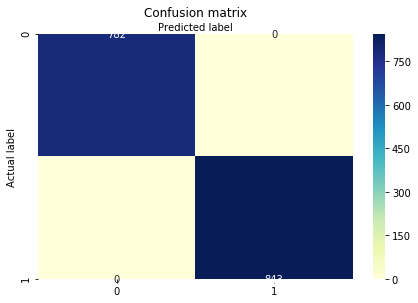

In [0]:
#visualization of confusion matrix
#credit goes to tutorial listed above
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap, confusion matrix calculated above
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Because of the 100% accuracy of our model, the confusion matrix naturally only contains entries in True Positive and False Negative, thus not providing us with any additional information. 

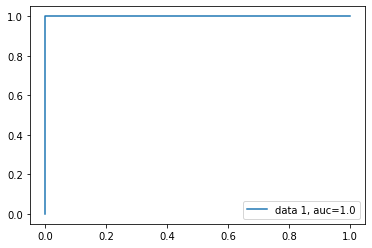

In [0]:
#AUC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Once again, because our model correctly labeled all test data into their appropriate categories, the AUC is naturally 1.

#Analysis

Because our model claimed to achieve 100% accuracy, the differing evaluation metrics we collected do not provide differing points of view on the model- all metrics show the highest ideal performance for their respective problems.   
It is difficult to make assumptions about the usefulness of this model. An overly optimistic data scientist would assume that we have created an ideal model and that mushrooms can be perfectly separated by their edibility. However, in reality, it would be wrong to assume such things, especially when an incorrect placement of a mushroom could lead to the consumption of something deadly. Because of this, a wise data scientist would attempt to test this model on more examples. Ideally, one would look for new data sets with different mushrooms than those found in this set and attempt to retest this model in order to measure its true effectiveness.

#Things I learned in this lab
For future reference and reflection.
* What can be done with datasets that lend themselves well to logistic regression
* How to deal with data that has many categorical fields
  * Pandas's built-in function get_dummies
* How to measure the effectiveness of a model in a variety of ways
* Caveats of models that deal with high-risk data (here, problems that can lead to injury or even death)
* What can lead to "perfect" models
* Visualizing confusion matrices and AUC curves

Credits go to Matthew Ko for being a great partner. Thanks dude.